In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 250
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,100),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        D = np.linalg.norm(Uto-Uf)**2
        #print(f"Uf: {Uf}")
        #print(f"Uto: {Uto}")
        #print(f"Valores de u: {u}")
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Uto, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        rho_vector[0][t] = pt[0][0]
        rho_vector[1][t] = pt[0][1]
        rho_vector[2][t] = pt[1][0]
        rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        if fid_autores[-1] < 0.9995:
            tempo_de_parada = t
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            aas.append((u[0],u[1],u[2]))
            #print(f"Tempo: {t}")
            Ut = Uto
        if fid_autores[-1] > 1:
            #print(f"Precisão anterior: {fid_autores[-2]} ou estado: {fid_vector[-2]}")
            #print(f"Tempo: {t} com precisão de porta: {fid_autores[-1]}, com precisão de estado: {fid_vector[-1]}")
            distance_vector.pop()
            fx_vector.pop()
            fy_vector.pop()
            fz_vector.pop()
            fid_vector.pop()
            fid_autores.pop()
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            t -= 1
        t += 1

    tempo_de_parada += 1
    print(f"Tempo de parada: {tempo_de_parada}")
    print(f"O rho gerado foi: {pt}")
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas, tempo_de_parada

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Tempo: 1
Começará a função principal
Tempo de parada: 42
O rho gerado foi: [[np.float64(1.0012417701568408), np.complex128(-0.006714736797446054-0.014438406587739643j)], [np.complex128(-0.006714736797446054+0.014438406587739643j), np.float64(-0.0012417701568406825)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014745196568782056-2.5315516536070263638e-05j'), np.clongdouble('0.50031650216376369393-9.1768097032378840795e-06j'), np.clongdouble('0.50064956662379671754+1.4874946468664788227e-05j'), np.clongdouble('0.5005204745360583889+0.00014469279898671574668j'), np.clongdouble('0.50099202221584341623+9.0443482758799918835e-06j'), np.clongdouble('0.4853900583732331025-3.4898118430537500325e-05j'), np.clongdouble('0.48599852715660090527-5.787653095115376501e-06j'), np.clongdouble('0.48613219312033245558+0.00014431201289034574846j'), np.clongdouble('0.48625592670062352905-0.00021122098498018558377j'), np.clongdouble('0.48635065686716820913+3.605146681815820789

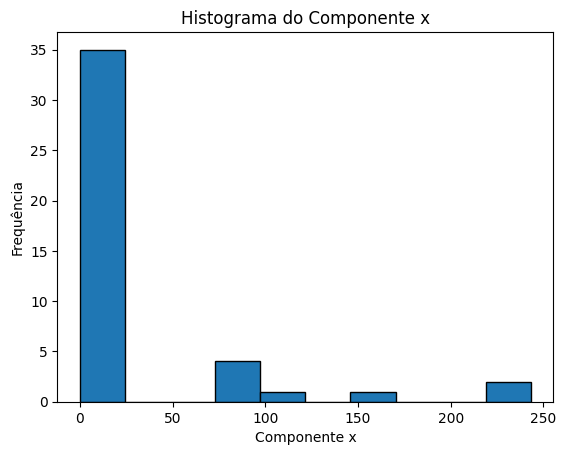

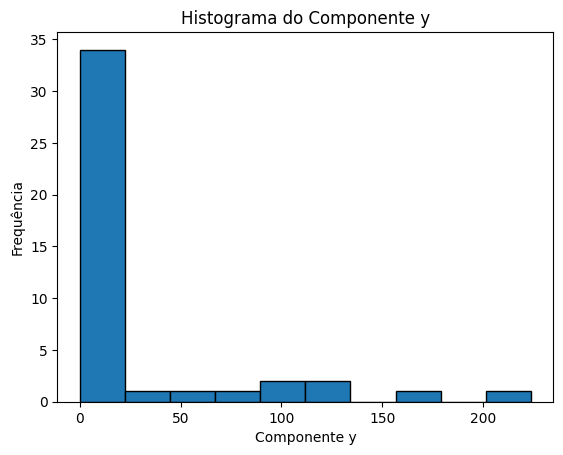

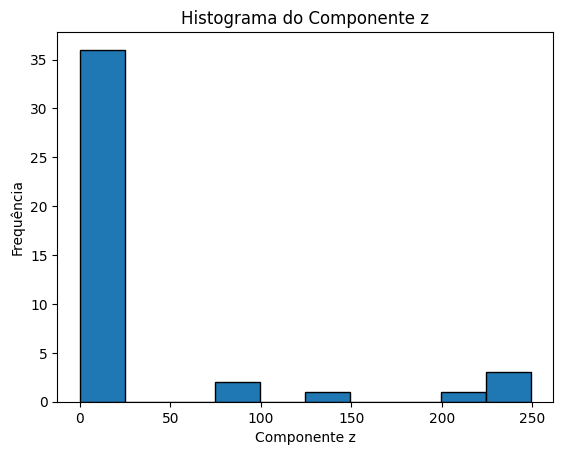

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.999538613542295
Estados: (1.0012445584868737+1.8890685150637607e-05j)
Distância: 0.01875468430260381
 
Tempo: 2
Começará a função principal
Tempo de parada: 57
O rho gerado foi: [[np.float64(1.0051454923472456), np.complex128(-0.00016700613716299375+0.0014973292773239023j)], [np.complex128(-0.00016700613716299375-0.0014973292773239023j), np.float64(-0.005145492347245595)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.39884694879338490872-1.6109172076501969229e-05j'), np.clongdouble('0.39876273705365492426+2.3849732723964456453e-05j'), np.clongdouble('0.3986754510932941497+4.381269762730503704e-16j'), np.clongdouble('0.39858707379539804846-0.0001919532616069422469j'), np.clongdouble('0.3990308774983850832+2.8834329671636914469e-05j'), np.clongdouble('0.4371105915706485114+2.5486555702151546144e-12j'), np.clongdouble('0.43701192086258119218-0.00024237117973749577894j'), np.clongdouble('0.612274985

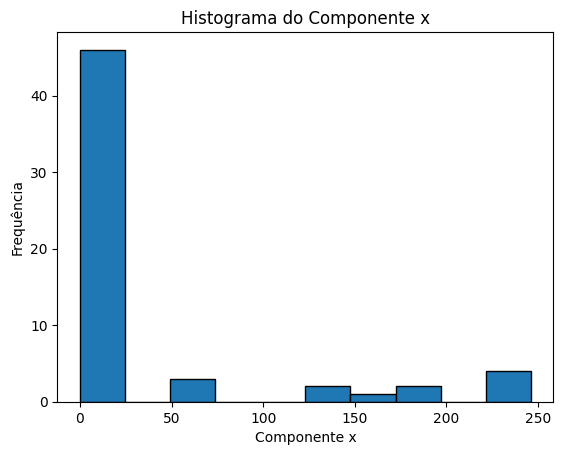

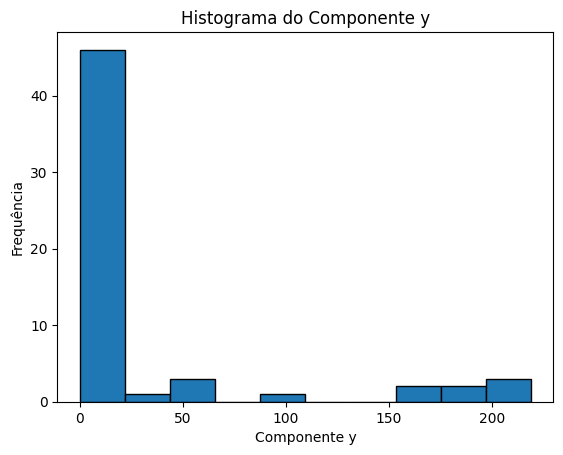

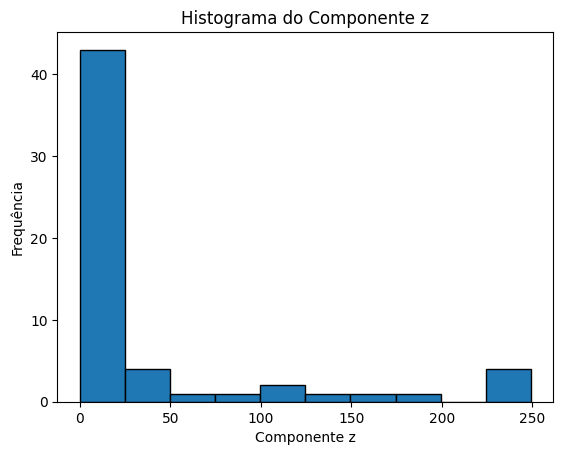

Terminou o histograma
Valores de média na iteração 2:
Portas: 0.9997117174256038
Estados: (1.0031950130860665+8.809738050398398e-06j)
Distância: 0.0412315754676888
 
Tempo: 3
Começará a função principal


/tmp/ipykernel_5994/116918231.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  f = -a*SA-h*(SB/SA)


Tempo de parada: 53
O rho gerado foi: [[np.float64(0.9997830835762112), np.complex128(-0.008571252047871585-0.03909136155409866j)], [np.complex128(-0.008571252047871585+0.03909136155409866j), np.float64(0.00021691642378879328)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.38985035236201821053+0j'), np.clongdouble('0.3899031197325321786-4.6949036301974499917e-09j'), np.clongdouble('0.39003608628304933134-8.277549399466138272e-06j'), np.clongdouble('0.39008196645843710193-4.5984924177792494436e-06j'), np.clongdouble('0.39003056012243794156-6.253078433553089195e-06j'), np.clongdouble('0.3900177187161833006+1.31708531661647677824e-05j'), np.clongdouble('0.40250328411526136094-0.00028647014545778382944j'), np.clongdouble('0.4025506264393165735+6.7477586302556037136e-05j'), np.clongdouble('0.4025845383588722942+3.3167471485194985005e-05j'), np.clongdouble('0.4026264358922998548+5.823829487354328584e-06j'), np.clongdouble('0.3802548165812837118-0.00018191259054524

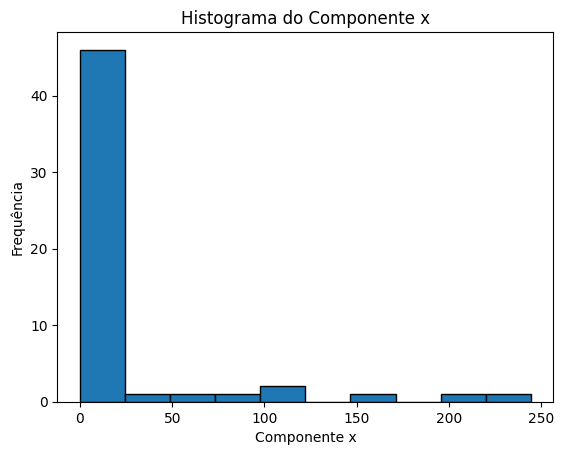

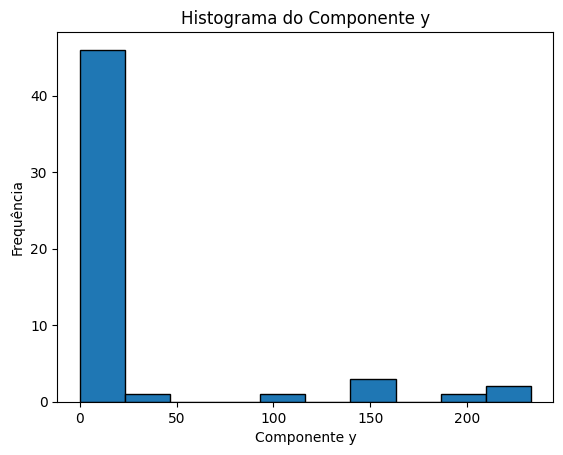

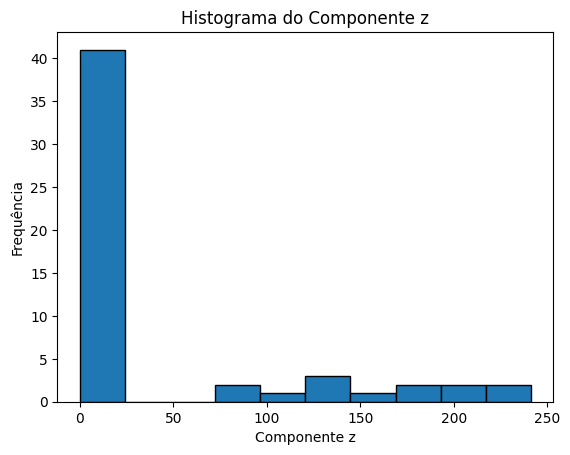

Terminou o histograma
Valores de média na iteração 3:
Portas: 0.9997673959929312
Estados: (1.0020605808749632-7.45007732988771e-06j)
Distância: 0.0317212128851404
 
Tempo: 4
Começará a função principal
Tempo de parada: 100
O rho gerado foi: [[np.float64(0.9962029075347074), np.complex128(-5.761952503066e-05+0.10193090583449764j)], [np.complex128(-5.761952503066e-05-0.10193090583449764j), np.float64(0.0037970924652926397)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.500204929248132681+0j'), np.clongdouble('0.4152087058852458243+0.000107917663907254111757j'), np.clongdouble('0.41542632747848705447-2.2233070683980554061e-05j'), np.clongdouble('0.42794758733078253854+7.987139270522281743e-05j'), np.clongdouble('0.42807778775734532314+4.1152629654168723958e-05j'), np.clongdouble('0.5274188549161960676-0.0002205747618648196178j'), np.clongdouble('0.5277320355489178396-3.0322440001830097897e-06j'), np.clongdouble('0.68169928503605721-8.564271337917455472e-05j'), 

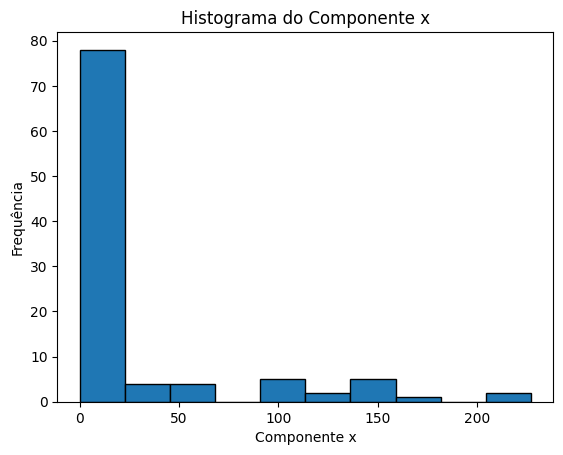

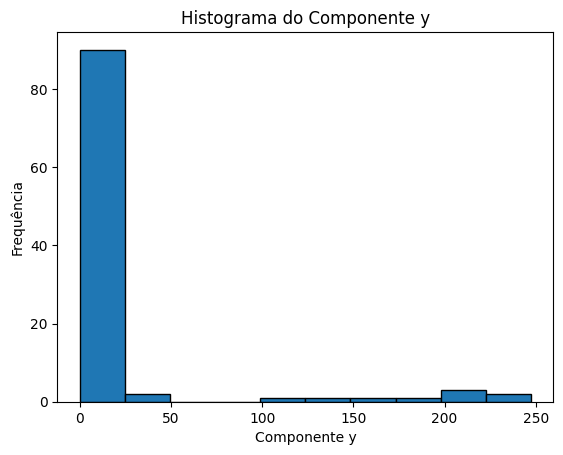

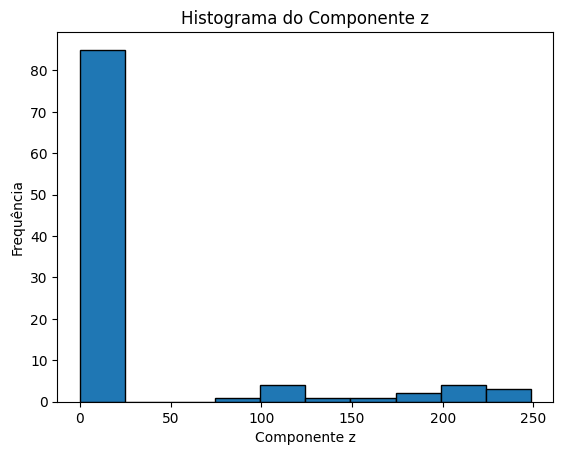

Terminou o histograma
Valores de média na iteração 4:
Portas: 0.9995866614034248
Estados: (1.0005976037588273+1.3755041205424018e-05j)
Distância: 0.04432724605309125
 
Tempo: 5
Começará a função principal
Tempo de parada: 100
O rho gerado foi: [[np.float64(0.9856886802413087), np.complex128(-0.007529922428193355-0.15330296027376228j)], [np.complex128(-0.007529922428193355+0.15330296027376228j), np.float64(0.014311319758691321)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.4313345123155291308+0.00013908235269512652136j'), np.clongdouble('0.43155642127803657004+4.866189095279522314e-05j'), np.clongdouble('0.431258499025235044+0.00019635756581917246725j'), np.clongdouble('0.4312171921936060285+0.00024044481304078285095j'), np.clongdouble('0.43118272758133932543+0.00019300446487415716849j'), np.clongdouble('0.43130172635401665629-0.00011338669234853674502j'), np.clongdouble('0.431485942409710419-0.00022846684253169958311j'), np.clongdouble('0.475997229688915529

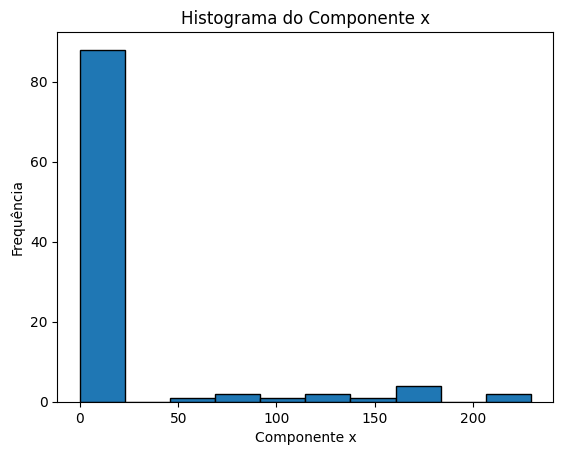

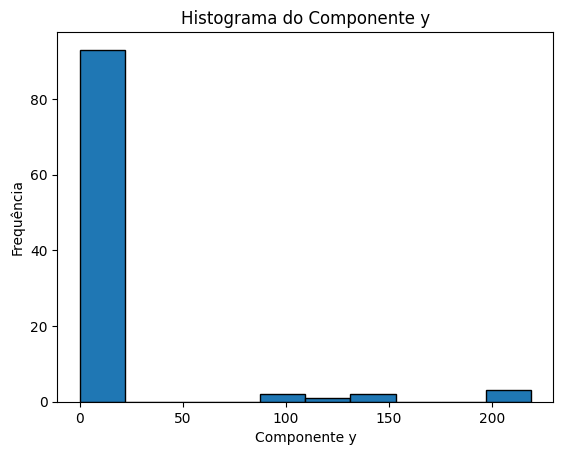

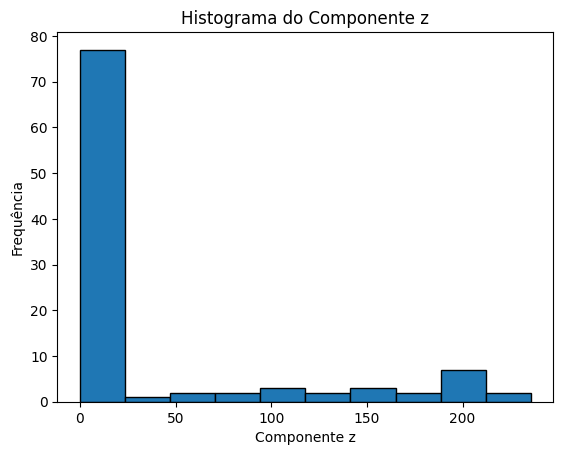

Terminou o histograma
Valores de média na iteração 5:
Portas: 0.999413810189236
Estados: (0.9976221233253452+2.9131650838234678e-05j)
Distância: 0.0740216986787613
 
Tempo: 6
Começará a função principal
Tempo de parada: 38
O rho gerado foi: [[np.float64(0.999514269469569), np.complex128(0.018283194737990657-0.03536607365430432j)], [np.complex128(0.018283194737990657+0.03536607365430432j), np.float64(0.00048573053043099446)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.50009077036937682557-5.0162697325997195927e-08j'), np.clongdouble('0.49961525902483658372+0.00029022101029946109244j'), np.clongdouble('0.49964240659745116555-4.5420622264326903567e-06j'), np.clongdouble('0.51407439809481342605+0.00021013174695526642796j'), np.clongdouble('0.52683972458163017997+1.7523046610117942043e-06j'), np.clongdouble('0.52653930578815853514-0.0002072298142207057695j'), np.clongdouble('0.6934546894009037479+8.434969733641511478

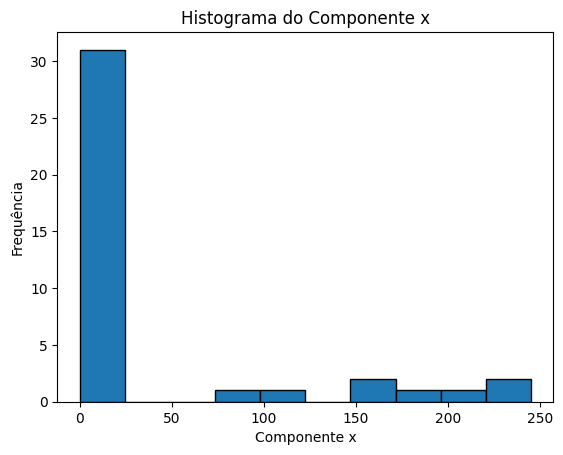

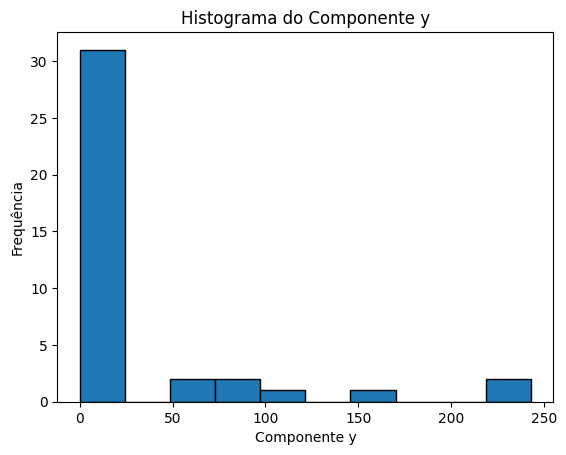

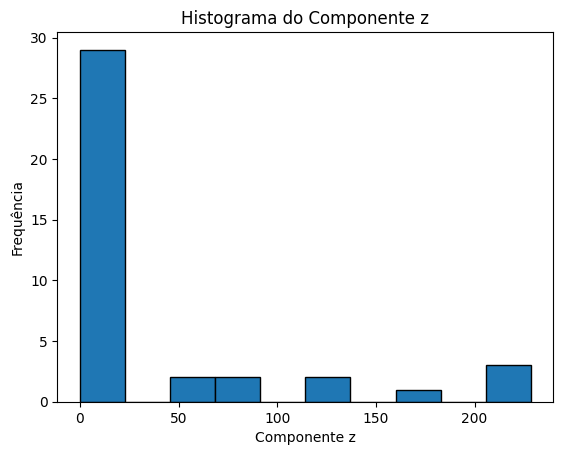

Terminou o histograma
Valores de média na iteração 6:
Portas: 0.9995103852593384
Estados: (0.9979446479675418+2.349393624886223e-05j)
Distância: 0.06393052073832445
 
Tempo: 7
Começará a função principal
Tempo de parada: 100
O rho gerado foi: [[np.float64(1.0036525564367698), np.complex128(0.0007073752414304552-0.00030074838397644595j)], [np.complex128(0.0007073752414304552+0.00030074838397644595j), np.float64(-0.0036525564367696495)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50020528586914731985-6.8705645023835011786e-16j'), np.clongdouble('0.51156542245250147597+0.0003587699416838553868j'), np.clongdouble('0.5117062820646360435-0.00025810028516361977492j'), np.clongdouble('0.5117361142233525933-0.00020592664960533531507j'), np.clongdouble('0.5118939792715108385-2.6232840575847397357e-05j'), np.clongdouble('0.57427290667428365775-0.00022932212747656226254j'), np.clongdouble('0.62542967091026217526-1.620120886957499513e-05j'), np.clongdouble('0.723823697

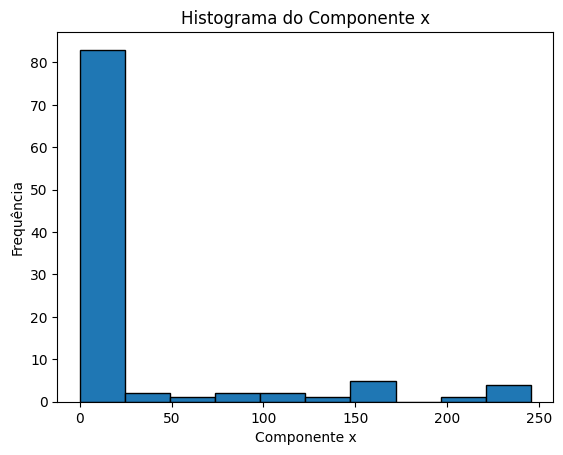

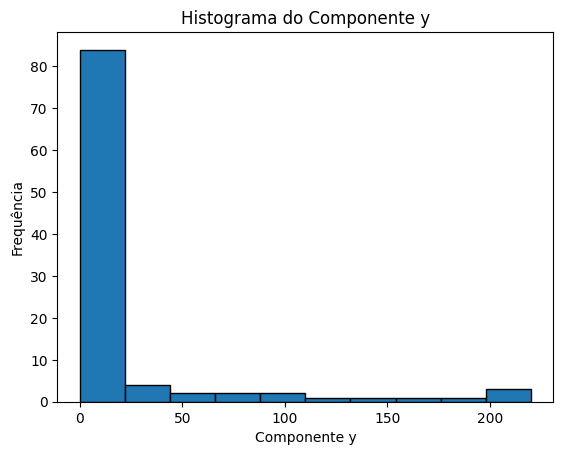

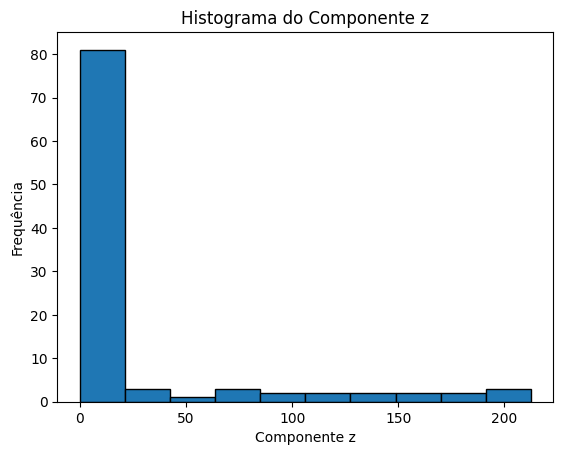

Terminou o histograma
Valores de média na iteração 7:
Portas: 0.9991550450862319
Estados: (0.9987600878827015+2.0023631349103824e-05j)
Distância: 0.06250590372682625
 
Tempo: 8
Começará a função principal
Tempo de parada: 100
O rho gerado foi: [[np.float64(0.9980692880152324), np.complex128(-0.0002285977653328054-0.050507434617421826j)], [np.complex128(-0.0002285977653328054+0.050507434617421826j), np.float64(0.0019307119847675192)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.49967008277188549196-5.0449552999674750813e-08j'), np.clongdouble('0.499087579708982939-0.00014481866225722054798j'), np.clongdouble('0.49882758917699654652-1.0345517363522149061e-14j'), np.clongdouble('0.49851137938170674656+0.00014382364872825472852j'), np.clongdouble('0.5739808869253056771-0.00016281843430846128983j'), np.clongdouble('0.5741426714197041102+9.828552911341114127e-05j'), np.clongdouble('0.57419568783638848806+0.000210548024

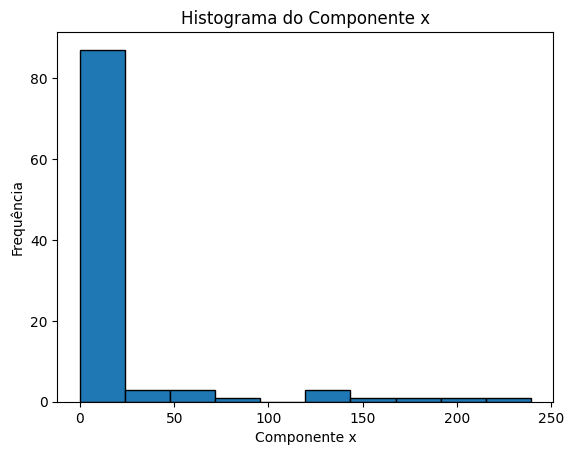

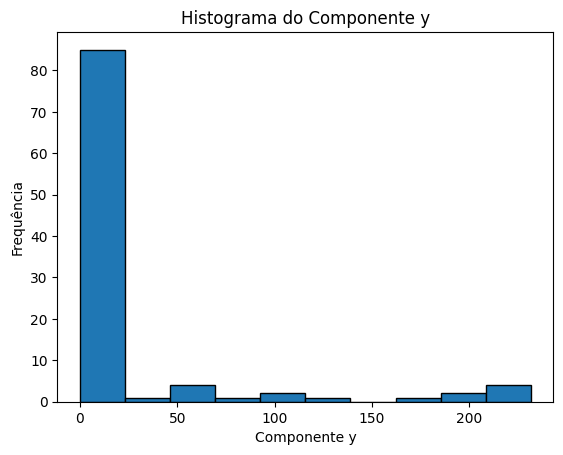

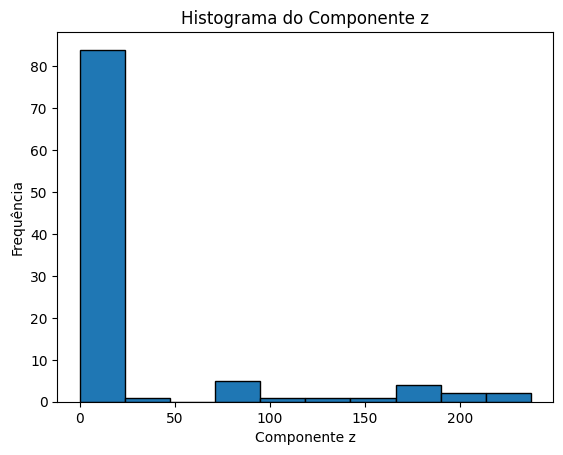

Terminou o histograma
Valores de média na iteração 8:
Portas: 0.999093727237744
Estados: (0.9986775747211132+1.799380334411641e-05j)
Distância: 0.05718581777772034
 
Tempo: 9
Começará a função principal
Tempo de parada: 40
O rho gerado foi: [[np.float64(0.9939689713885793), np.complex128(-0.0919447760612218+0.0709472977382434j)], [np.complex128(-0.0919447760612218-0.0709472977382434j), np.float64(0.006031028611420686)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.42047022155279614015+0.00019788724271051331501j'), np.clongdouble('0.42053118216524522819+0.00012768686944854141069j'), np.clongdouble('0.42040753548128865895-0.0002855473968878781824j'), np.clongdouble('0.42456108099175718823-0.00017874062990502668148j'), np.clongdouble('0.42457026940207111043+9.551990122891669911e-05j'), np.clongdouble('0.42460119979526643022+0.00013964414760316247122j'), np.clongdouble('0.46810841477627934947+9.9097645704353704135e-05

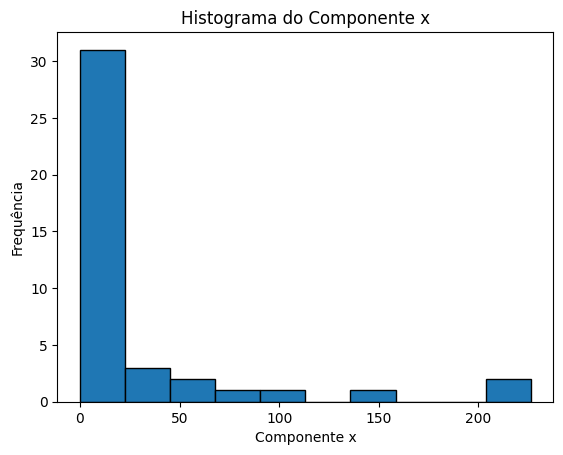

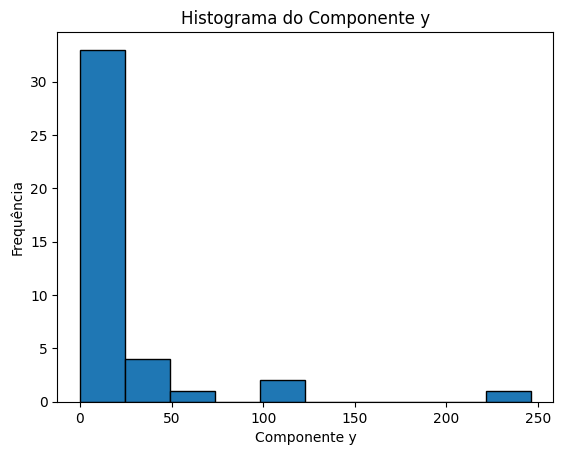

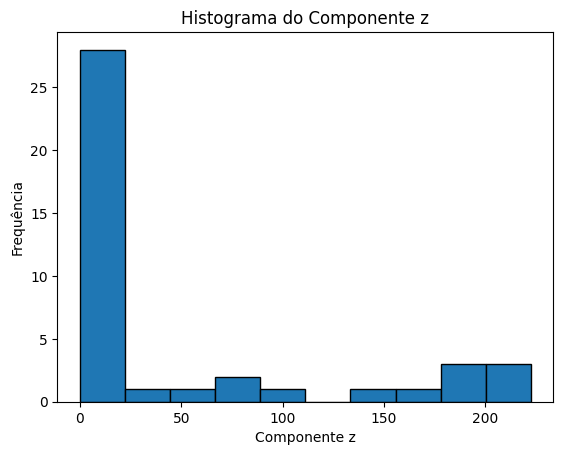

Terminou o histograma
Valores de média na iteração 9:
Portas: 0.999169627733855
Estados: (0.998161328301498+1.7644873965523194e-05j)
Distância: 0.06286986377331255
 
Tempo: 10
Começará a função principal
Tempo de parada: 49
O rho gerado foi: [[np.float64(0.9999580423115407), np.complex128(-0.0021955060643055863-0.013088831124955876j)], [np.complex128(-0.0021955060643055863+0.013088831124955876j), np.float64(4.195768845927095e-05)]]
Terminou a função principal
Veja o log: (Dos estados)
[np.clongdouble('0.50014465186685759925+0j'), np.clongdouble('0.49990138342621843876+5.6462594832435939648e-05j'), np.clongdouble('0.5710284560375769156-0.00038505876197684815005j'), np.clongdouble('0.5711632238576873983+0.00013971497351923294056j'), np.clongdouble('0.57127110750891832924+0.00016046521085609862926j'), np.clongdouble('0.6324819160065548386-0.000109555443410562655196j'), np.clongdouble('0.6326251387023493562-3.811956771147353587e-06j'), np.clongdouble('0.63976311065871677576+0.0002608447063

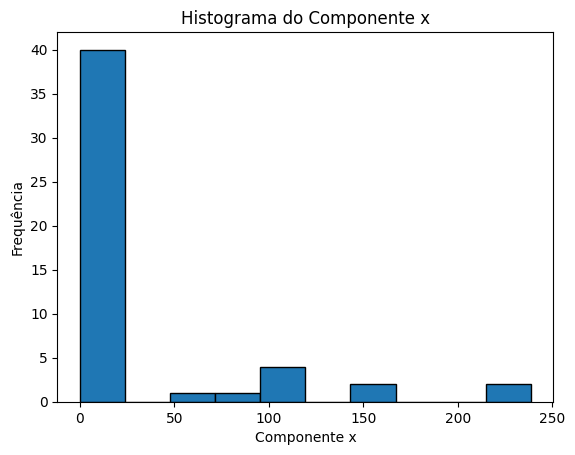

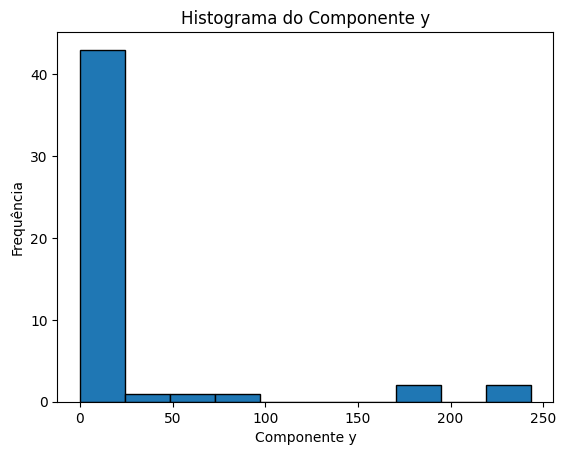

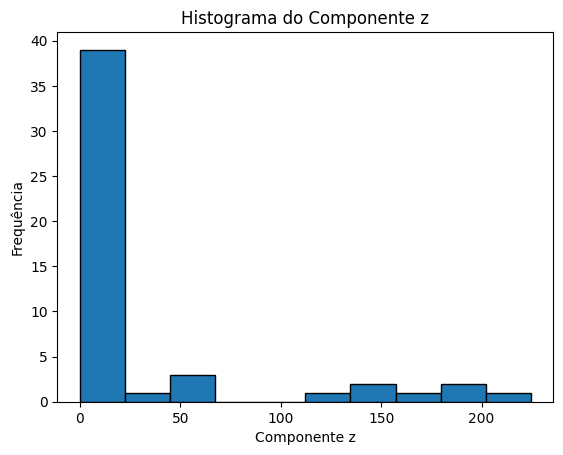

Terminou o histograma
Valores de média na iteração 10:
Portas: 0.9992138915568549
Estados: (0.998342264061888+1.5898958073799992e-05j)
Distância: 0.05677560962420388
 


In [21]:
portas = []
estados = []
distancia = []

for i in range(1, 11):

    print(f"Tempo: {i}")

    print(f"Começará a função principal")
    fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a, tempo_de_parada = main()
    print(f"Terminou a função principal")
    print(f"Veja o log: (Dos estados)")
    print(fid_vector)
    print(f"Veja o log: (Das portas)")
    print(fid_autores)

    portas.append(fid_autores[-1])
    estados.append(fid_vector[-1])
    distancia.append(distance_vector[-1])

    print(f"Começou o histograma")
    histograma(0, a)
    histograma(1, a)
    histograma(2, a)
    print(f"Terminou o histograma")
    
    print(f"Valores de média na iteração {i}:")
    print(f"Portas: {sum(portas)/i}")
    print(f"Estados: {sum(estados)/i}")
    print(f"Distância: {sum(distancia)/i}")
    print(" ")